In [62]:
from openai import OpenAI

import os
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Retrieve the API key
OpenAI_api_key = os.getenv("OPEN_AI_KEY")

In [63]:
def extractData(filename, numLine):
    df = pd.read_csv(filename)
    df_limit = df[0:numLine]
    if filename == "trac2_CONVT_train.csv":
        df_limit_target = df_limit[["text", "Emotion", "EmotionalPolarity", "Empathy"]]
    else:
        df_limit_target = df_limit[["text"]]
    return df_limit_target


df_train = extractData("trac2_CONVT_train.csv", 500)
df_test = extractData("trac2_CONVT_dev.csv", 100)
df_test

df_train_text = df_train.to_markdown(index=False)
df_test_text = df_test.to_markdown(index=False)

with open("input.txt", "w", encoding="utf-8") as f:
    f.write(df_train_text)

with open("test.txt", "w", encoding="utf-8") as f:
    f.write(df_test_text)


In [70]:
client = OpenAI(api_key=OpenAI_api_key)

prompt = f"""
I will give you a list of train data, your task is to predict and return the correct labels for the test data
The goal of this task is, given a conversational turn, to predict its associated emotion intensity, polarity, and empathy level.
The emotional polarity is a categorical variable indicating positive, neutral, and negative emotions. 
The emotion intensity and empathy, on the other hand, are measured on ordinal scales ranging from not likely (0) to very likely (5).
The task is classification for emotional polarity, and regression for emotional intensity and empathy.
Here is the list of data for your training:

{df_train_text}

Here is the list of data you need to predict:

{df_test_text}

Return in the most suitable format for evaluation (json) like this
[
  {{"text": "Hello how are you?", "Emotion": 1, "EmotionalPolarity": 1, "Empathy": 1}},
  ...
]
"""

response = client.chat.completions.create(
    model="gpt-5",
    messages=[
        {"role": "system", "content": "You are an AI model that helps with regression and classification task"},
        {"role": "user", "content": prompt}
    ],
    temperature=1 
)

with open("LLM_output.txt", "w", encoding="utf-8") as f:
    f.write(response.choices[0].message.content)

In [74]:
import json
import numpy as np
with open("LLM_output.txt", "r", encoding="utf-8") as f:
    predictions = json.load(f)

df_predictions = pd.DataFrame(predictions)

def processOutput(df):
    emotionColumnIndex = df.columns.get_loc("Emotion")
    emotionPolarityColumnIndex = df.columns.get_loc("EmotionalPolarity")
    emphathyColumnIndex = df.columns.get_loc("Empathy")

    Y_reg = []
    Y_class = []
    instance = []
    df = df[0:100]

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionColumnIndex])
        instance.append(df.iloc[i, emphathyColumnIndex])
        Y_reg.append(instance)
        instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionPolarityColumnIndex])
        Y_class.append(instance)
        instance = []

    return np.array(Y_reg), np.array(Y_class)
y_reg_pred, y_class_pred = processOutput(df_predictions)


In [75]:
import numpy as np

df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])

Y_test_reg, Y_test_class = processOutput(df_test)

MSE per output: [0.5775 1.02  ]
RMSE per output: [0.75993421 1.00995049]
MAE per output: [0.525 0.7  ]
[[14  2  1]
 [ 6 46 14]
 [ 0  0 17]]


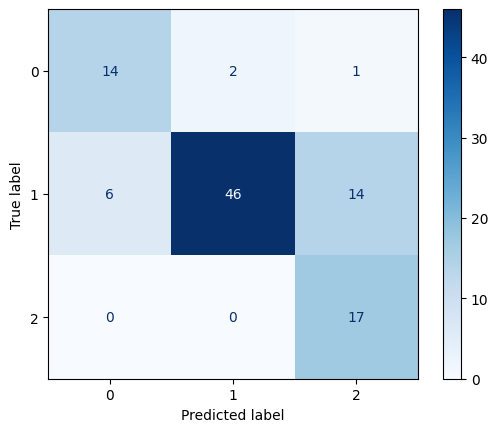

0.8418125000000001 0.77 0.7792394112694865 0.77


In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

mse = mean_squared_error(Y_test_reg, y_reg_pred, multioutput='raw_values')
print("MSE per output:", mse)

rmse = np.sqrt(mse)
print("RMSE per output:", rmse)

mae = mean_absolute_error(Y_test_reg, y_reg_pred, multioutput='raw_values')
print("MAE per output:", mae)

cm = confusion_matrix(Y_test_class, y_class_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print(precision, recall, f1, accuracy)